In [ ]:
%reset -f

In [1]:
"""
Create a multi-band TreeMap and LANDFIRE raster for analysis in the Southern Rockies
Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import seaborn as sns

os.environ["PROJ_LIB"] = "/opt/miniconda3/envs/aspen-fire/share/proj"

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


<Axes: >

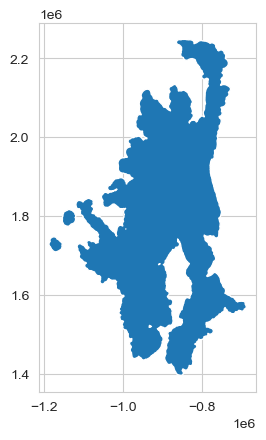

In [2]:
# load and prepare our study region for cropping TreeMap
# Southern Rockies ecoregion bounds (buffered)
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# Crop the raster by the SRM bounds
srm['geometry'] = srm.geometry.buffer(5000)
bounds = srm.total_bounds # total bounds of ecoregion
srm_wgs = srm.to_crs('EPSG:4326') # WGS version for REST services
srm.plot()

In [3]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y  # Latitude
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any duplicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx','Fire_ID'], keep='first')


There are [56974] grids across [76] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_first_day', 'frp_first_night',
       'Fire_ID', 'Fire_Name', 'n_grids', 'geometry', 'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



In [4]:
# create a smaller dataframe only keeping columns we need for now:
grid["day_prop"] = np.where(
    grid["afd_count"] > 0,
    grid["day_count"] / grid["afd_count"],
    0   # or 0, depending on what you want
)
grid = grid[[
    'grid_idx','frp_csum','overlap','afd_count','day_prop',
    'first_obs_date','last_obs_date',
    'x','y','geometry'
]]
grid.head()

,grid_idx,frp_csum,overlap,afd_count,day_prop,first_obs_date,last_obs_date,x,y,geometry
0,161955419,1.804557,0.066578,1,0.000,2022-06-16,2022-06-16,-105.602515,35.839649,"POLYGON ((-858421.57 1463991.096, -858046.57 1..."
1,161955420,2.560032,0.095111,2,0.000,2022-06-14,2022-06-16,-105.602937,35.842981,"POLYGON ((-858421.57 1464366.096, -858046.57 1..."
2,161955421,30.841694,0.461696,5,0.200,2022-06-10,2022-06-15,-105.603360,35.846313,"POLYGON ((-858421.57 1464741.096, -858046.57 1..."
3,161955422,19.031477,0.842557,8,0.125,2022-06-10,2022-06-15,-105.603782,35.849645,"POLYGON ((-858421.57 1465116.096, -858046.57 1..."
4,161955423,1.653068,0.296524,4,0.000,2022-06-10,2022-06-14,-105.604205,35.852977,"POLYGON ((-858421.57 1465491.096, -858046.57 1..."


Fractional overlap:
count    56974.000000
mean         2.313991
std          2.228445
min          0.000004
25%          0.714418
50%          1.736159
75%          3.155613
max         28.421857
Name: overlap, dtype: float64



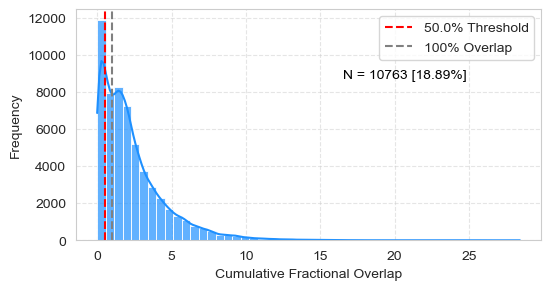

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png

Dropping [10763 (18.89%)] grids with <50.0% fractional overlap.
46211


In [5]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.50
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] <= thresh]['grid_idx'].count()

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.xlabel('Cumulative Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7,
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]',
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

# filter out grids below the overlap threshold
print(f"\nDropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

### Gather the USFS TreeMap ca. 2016 layers

In [6]:
# Load the TreeMap data (ca. 2016)
# Define input paths
tm_dir = os.path.join(maindir, 'data/landcover/USFS/RDS_TreeMap')
raster_files = {
    'tm_id': 'TreeMap2016/TreeMap2016.tif',
    'fortypcd': 'TreeMap2016_FORTYPCD/TreeMap2016_FORTYPCD.tif',
    'tm_balive': 'TreeMap2016_BALIVE/TreeMap2016_BALIVE.tif',
    'tm_tpa': 'TreeMap2016_TPA_LIVE/TreeMap2016_TPA_LIVE.tif'
}

# Helper to load and clip a raster
def load_and_clip_raster(fp, bounds):
    return rxr.open_rasterio(fp).squeeze().rio.clip_box(
        minx=bounds[0], miny=bounds[1], maxx=bounds[2], maxy=bounds[3]
    )

# Load and clip all rasters
clipped_rasters = {}
for key, rel_path in raster_files.items():
    full_path = os.path.join(tm_dir, rel_path)
    clipped_rasters[key] = load_and_clip_raster(full_path, bounds)

# Inspect one for metadata
ref = clipped_rasters['tm_id']
print(f"""
Shape: {ref.shape}
CRS: {ref.rio.crs}
NoData: {ref.rio.nodata}
Dtype: {ref.dtype}
Shape: {ref.shape}
""")

# Stack as xarray.Dataset
tm_stack = xr.Dataset(clipped_rasters)
print(f"\nCreated TreeMap data stack with {list(tm_stack.data_vars)}")
del clipped_rasters, ref
gc.collect()


Shape: (28392, 16673)
CRS: EPSG:5070
NoData: 2147483647
Dtype: int32
Shape: (28392, 16673)


Created TreeMap data stack with ['tm_id', 'fortypcd', 'tm_balive', 'tm_tpa']


556

In [7]:
# Create a data lookup table
# Extract arrays and flatten
tm_id_arr = tm_stack['tm_id'].values.flatten()
fortypcd_arr = tm_stack['fortypcd'].values.flatten()

# Mask out rows where tm_id is NaN (non-forest pixels)
valid_mask = ~np.isnan(tm_id_arr)

# Subset arrays to valid (non-NaN) pixels
tm_id_vals = tm_id_arr[valid_mask].astype(int)
fortypcd_vals = fortypcd_arr[valid_mask].astype(int)

lut = pd.DataFrame({
    'tm_id': tm_id_vals,
    'fortypcd': fortypcd_vals,
})

# Drop duplicates
lut = lut.drop_duplicates()

# Save to CSV
out_fp = os.path.join(projdir,'data/tabular/raw/tm_fortyp_lut.csv')
lut.to_csv(out_fp, index=False)
print(f"Saved lookup table to: {out_fp}")
del tm_id_arr, fortypcd_arr, valid_mask, tm_id_vals, fortypcd_vals
gc.collect()

Saved lookup table to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/raw/tm_fortyp_lut.csv


6115

In [8]:
# join the lookup table to forest type names
# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)
# merge to the lookup table
lut_fortyp = lut.merge(species_df, on='fortypcd')
# find aspen code
print(f"Aspen FORTYP code(s): {lut_fortyp[lut_fortyp['fortypnm'].str.contains("aspen", case=False, na=False)]['fortypcd'].unique()}")
del species_df

Aspen FORTYP code(s): [901]


In [9]:
# create a forest/non-forest grid, add to stack
ba = tm_stack['fortypcd']
nd = ba.rio.nodata

# make nans appropriately
ba = ba.where(ba != nd) if nd is not None else ba # fill nodata

# make the forest mask
forest_mask = xr.where((ba > 0).fillna(False), 1, 0).astype('uint8')
forest_mask = forest_mask.rename('forest')
forest_mask.rio.write_nodata(255, inplace=True) # write nodata

# add to the stack
tm_stack['forest'] = forest_mask
del ba
print(tm_stack)

<xarray.Dataset> Size: 7GB
Dimensions:      (x: 16673, y: 28392)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 133kB -1.188e+06 -1.188e+06 ... -6.881e+05
  * y            (y) float64 227kB 2.248e+06 2.248e+06 ... 1.397e+06 1.397e+06
    spatial_ref  int64 8B 0
Data variables:
    tm_id        (y, x) int32 2GB 11629 70802 12149 ... 2147483647 2147483647
    fortypcd     (y, x) uint16 947MB 266 266 266 65535 ... 65535 65535 65535
    tm_balive    (y, x) float32 2GB ...
    tm_tpa       (y, x) float32 2GB ...
    forest       (y, x) uint8 473MB 1 1 1 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0


## Gather LANDFIRE canopy cover

Add in some LANDFIRE data to the data stack for summarization at the gridcell level. This includes forest canopy cover (CC), canopy height (CH), canopy bulk density (CBD), and canopy base height (CBH). We also grab the EVT code which enables a comparison between TreeMap field forest type and the LF EVT.

In [10]:
# Grab some raster metadata from one of the layers to serve as a reference
tm_ref = tm_stack['tm_id'] # reference array
shp, gt, wkt, nd = tm_ref.shape, tm_ref.spatial_ref.GeoTransform, tm_ref.rio.crs, tm_ref.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tm_ref[0].dtype}")

Shape: (28392, 16673); 
GeoTransform: -1188315.0 30.0 0.0 2248365.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: 2147483647; 
Data Type: int32


In [11]:
fuel_vars = {
    'cc': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CC_19/ImageServer', # canopy cover
    # 'ch': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CH_19/ImageServer',
    'cbd': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CBD_19/ImageServer',
    # 'cbh': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CBH_19/ImageServer'
}

# add a function to match to TreeMap
def align_lf_to_tm(lf_da, tm_ref):
    """Reprojects and resamples LANDFIRE array to match TreeMap reference"""
    return lf_da.rio.reproject_match(
        tm_ref,
        resampling=Resampling.nearest  # Use 'nearest' for categorical data like EVT
    )

# get the fuels arrays
print("\nAccessing fuel rasters")

fuel_arrs = {} # to store the results
for var, url in fuel_vars.items():
    print(f"\nDownloading [{var}] raster from: {url}")
    # get the raster
    da = get_image_service_array(url, srm_wgs, out_prefix=var)
    # match to treemap
    da = align_lf_to_tm(da, tm_ref)
    # add the results to the data stack
    tm_stack[var] = da

    del da

del fuel_arrs

print("\nFuel rasters successfully processed and added to the stack.")


Accessing fuel rasters



Fuel rasters successfully processed and added to the stack.


In [12]:
# create a binary aspen / non-aspen mask
aspen_mask = xr.where(tm_stack['fortypcd']==901, 1, 0).astype('uint8') # 901 = aspen
aspen_da = aspen_mask.rename('aspen') # rename the band
aspen_da.rio.write_crs(tm_stack.rio.crs, inplace=True) # write the crs
aspen_da.rio.write_nodata(255, inplace=True) # explicitly write nodata

# chunk before writing if the array is large (helps memory)
aspen_da = aspen_da.chunk({'y': 2048, 'x': 2048})

# Write a tiled, compressed GeoTIFF (fast reads; safe BigTIFF if needed)
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/tm_aspen_mask.tif")
aspen_da.rio.to_raster(
    out_fp,
    driver="GTiff",
    dtype="uint8",
    tiled=True,
    blockxsize=512,
    blockysize=512,
    compress="zstd",   # or "deflate" if you prefer
    zstd_level=9,
    BIGTIFF="IF_SAFER"
)
print(f"Saved aspen mask to: {out_fp}")
del aspen_mask, aspen_da

Saved aspen mask to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/tm_aspen_mask.tif


In [13]:
# check the final data stack
print(f"\nCreated TreeMap data stack with {list(tm_stack.data_vars)}")


Created TreeMap data stack with ['tm_id', 'fortypcd', 'tm_balive', 'tm_tpa', 'forest', 'cc', 'cbd']


## Summarize data within gridcells

For each raster layer, calculate the appropriate zonal statistics within FRP grid cells.

- TM_ID: The FIA plot identifier (TreeMap); calculate the count and proportion for each TM_ID in grid cells.
- FORTYPCD: The algorithmic forest type code (TreeMap); calculate the count and proportion
- TM_BALIVE: The pixel-level live basal area (TreeMap); calculate the sum per grid cell
- TM_TPA: The pixel-level trees/acre (TreeMap); calculate the sum per grid cell
- FOREST: Binary forest / non-forest layer (TreeMap); calculate the count and proportion
- EVT: Existing Vegetation Type (LANDFIRE); calculate the count and proportion
- CC: forest canopy cover (LANDFIRE); calculate the mean per grid cell
- CH: forest canopy height (LANDFIRE); calculate the mean per grid cell
- CBD: canopy bulk density (LANDFIRE); calculate the mean per grid cell
- CBH: canopy base height (LANDFIRE); calculate the mean per grid cell
- ASPEN: Binary aspen grid (TreeMap); Pylandstats patch metrics

In [14]:
# map over the raster layers and calculate gridcell statistics.
data_vars = list(tm_stack.data_vars) # raster bands
zs_results = {} # to store the results
for da in data_vars:
    print(f"Processing [{da}]")

    # get the raster
    da_arr = tm_stack[da]

    # apply forest mask for fuels (skip categorical & forest itself)
    if da in ['cc', 'ch', 'cbd', 'cbh']:
        # mask non-forest pixels to NaN
        da_arr = da_arr.where(tm_stack['forest'] == 1)

    # calculate the proportion for categorical rasters
    if da in ['tm_id', 'fortypcd', 'forest']:
        # categorical stats
        zs = compute_band_stats(
            grid, da_arr,
            id_col='grid_idx',
            attr=str(da)
        )
        zs.rename(columns={
            'pct_cover': da+'_pct',
            'total_pixels': da+'_npix'
        }, inplace=True)
    else:
        # continuous stats (mean only)
        zs = compute_band_stats(
            grid, da_arr,
            id_col='grid_idx',
            attr=str(da),
            stats=['mean'],
            ztype='continuous'
        )
    # add to the dictionary
    zs_results[da] = zs

    # save a csv output
    out_fp = os.path.join(projdir, f"data/tabular/mod/results/summaries/{da}.csv")
    os.makedirs(os.path.dirname(out_fp), exist_ok=True)
    zs.to_csv(out_fp, index=False)

    del zs

# clean up
del tm_ref, tm_stack

# check on the results
print(f"TM_ID:\n{zs_results['tm_id'].head()}")
print(f"FLDTYPCD:\n{zs_results['tm_id'].head()}")
print(f"CC:\n{zs_results['cc'].head()}")
print(f"Forest:\n{zs_results['forest'].head()}")

Processing [tm_id]
Processing [fortypcd]
Processing [tm_balive]
Processing [tm_tpa]
Processing [forest]
Processing [cc]
Processing [cbd]
TM_ID:
    grid_idx  tm_id  count  tm_id_npix  tm_id_pct
0  161955422   4109    1.0       167.0   0.598802
1  161955422   9572    6.0       167.0   3.592814
2  161955422  11520    1.0       167.0   0.598802
3  161955422  12274    1.0       167.0   0.598802
4  161955422  12582    3.0       167.0   1.796407
FLDTYPCD:
    grid_idx  tm_id  count  tm_id_npix  tm_id_pct
0  161955422   4109    1.0       167.0   0.598802
1  161955422   9572    6.0       167.0   3.592814
2  161955422  11520    1.0       167.0   0.598802
3  161955422  12274    1.0       167.0   0.598802
4  161955422  12582    3.0       167.0   1.796407
CC:
    grid_idx    cc_mean
0  161955422  44.820359
1  161957669  57.197802
2  161957670  60.051020
3  161957671  62.912088
4  161957672  53.704663
Forest:
    grid_idx  forest  count  forest_npix  forest_pct
0  161955422       0     15          

In [15]:
print(f"Forest:\n{zs_results['forest'].head()}")

Forest:
    grid_idx  forest  count  forest_npix  forest_pct
0  161955422       0     15          182    8.241758
1  161955422       1    167          182   91.758242
2  161957669       1    182          182  100.000000
3  161957670       1    196          196  100.000000
4  161957671       1    182          182  100.000000


# Calculate tree-level summaries from the Tree Table

The Tree Table forms the basis for much of the analysis. Here we link the tree table to the summary of TM_IDs (FIA plot identifier) by grid cell in the Southern Rockies. We assess FIA data with species that are likely to occur in the Southern Rockies to remove spurious FIA imputed plots. Then we look at the species co-occurrence, create some species groupings, and subset to the forest species that make up 97% of live basal area on the landscape.

In [16]:
# load the TreeMap Tree Table
fp = os.path.join(maindir, 'data/landcover/USFS/RDS_TreeMap/TreeMap2016/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')


In [17]:
# get the TM_ID summary table
tmid = zs_results['tm_id']

# subset the tree table columns to those we want to keep
tree_tbl = tree_tbl[[
    'tm_id','COMMON_NAME','SPECIES_SYMBOL',
    'TPA_UNADJ','DIA','ACTUALHT','TREE','STATUSCD'
]]

# join the Tree Table to the grid data
grid_trees = tmid.merge(tree_tbl, on='tm_id')
print(f"\n{grid_trees.head()}")
del tree_tbl


    grid_idx  tm_id  count  tm_id_npix  tm_id_pct     COMMON_NAME  \
0  161955422   4109    1.0       167.0   0.598802     blue spruce   
1  161955422   4109    1.0       167.0   0.598802     blue spruce   
2  161955422   4109    1.0       167.0   0.598802     blue spruce   
3  161955422   4109    1.0       167.0   0.598802  ponderosa pine   
4  161955422   4109    1.0       167.0   0.598802     blue spruce   

  SPECIES_SYMBOL  TPA_UNADJ   DIA  ACTUALHT  TREE  STATUSCD  
0           PIPU   6.018046  11.4      51.0     1         1  
1           PIPU   6.018046  14.4      60.0     2         1  
2           PIPU   6.018046   5.1      28.0     3         1  
3           PIPO   6.018046   8.4       8.0     1         2  
4           PIPU   6.018046  12.5      51.0     1         2  


In [18]:
# drop null values of the tree/acre expansion factor
N=len(grid_trees)
grid_trees = grid_trees.dropna(subset=['TPA_UNADJ','DIA','ACTUALHT','COMMON_NAME'])
print(f"Dropped [{N-len(grid_trees)}] rows with null values for structure metrics.")

Dropped [2249105] rows with null values for structure metrics.


In [19]:
# Calculate the Tree Table forest structure statistics across tm_id/grid_index combinations
#### Abundance (trees/acre)
#### Dominance (live basal area)
#### Forest structure:
#### ~ Tree height/diameter ratio
#### ~ Quadratic mean diameter

# force species name to lower case
grid_trees.rename(columns={
    'COMMON_NAME': 'species',
    'STATUSCD': 'live_dead'
}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# calculate live basal area (balive) scaled by TPA
grid_trees['DIA2'] = grid_trees['DIA'] ** 2 # diameter squared
grid_trees['BA'] = 0.005454 * grid_trees['DIA2']  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['TPA_UNADJ']  # now adjust based on tree abundance
# calculate the quadratic mean diameter at the plot-species level
grid_trees['DIA2_TPA'] = grid_trees['DIA2'] * grid_trees['TPA_UNADJ']
# height-diameter ratio
grid_trees['HDR'] = grid_trees['ACTUALHT'] / grid_trees['DIA']

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead separately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        tmid_npix=('tm_id_npix','max'), # retains the tm_id pixel count
        tmid_pct=('tm_id_pct','max'), # retain the percent of forested area
        tpa_live=('TPA_UNADJ','sum'), # sum of the trees/pixel
        ba_live=('BA_TPAsc', 'sum'), # total BALIVE
        # calculate the quadratic mean diameter
        qmd_live=('DIA2_TPA', lambda x: np.sqrt(x.sum() / grid_trees.loc[x.index, 'TPA_UNADJ'].sum())),
        # calculate the height-diameter ratio weighted by TPA
        hdr_live=('HDR', lambda x: np.average(x, weights=grid_trees.loc[x.index, 'TPA_UNADJ']))
    )
)

# get the dead basal area and tpa
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 2]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        tpa_dead=('TPA_UNADJ','sum'), # sum of the trees/pixel
        ba_dead=('BA_TPAsc', 'sum'), # basal area
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics,
    on=['grid_idx', 'tm_id', 'species'],
    how='outer'
).fillna(0)

# filter out rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_npix'] > 0]
print(f"\n{tree_metrics.head(12)}\n")

del live_metrics, dead_metrics, grid_trees


   grid_idx  tm_id                  species  tmid_npix  tmid_pct     tpa_live  \
0   0819719  11444            quaking aspen      177.0  0.564972    54.162414   
1   0819719  11444  southwestern white pine      177.0  0.564972     6.018046   
2   0819719  11444                white fir      177.0  0.564972    72.216552   
3   0819719  11489            quaking aspen      177.0  2.824859    66.198506   
4   0819719  11489                white fir      177.0  2.824859    42.126322   
5   0819719  11500            quaking aspen      177.0  0.564972   357.292852   
6   0819719  11500                white fir      177.0  0.564972   120.360920   
7   0819719  11777               gambel oak      177.0  4.519774    24.072184   
8   0819719  11777            quaking aspen      177.0  4.519774   165.235970   
9   0819719  11798            quaking aspen      177.0  1.129944   132.397012   
10  0819719  11881           lodgepole pine      177.0  0.564972   224.895840   
11  0819719  11881         

In [20]:
# gather the unique species present across grid cells
unique_spp = tree_metrics['species'].value_counts()
unique_spp

species
ponderosa pine        472773
lodgepole pine        373877
douglas-fir           349256
quaking aspen         311192
subalpine fir         243532
                       ...  
honeylocust                1
screwbean mesquite         1
blue oak                   1
tamarack                   1
willow spp.                1
Name: count, Length: 124, dtype: int64

In [21]:
# filter to species of interest
# these represent major tree species of the Southern Rockies
srm_species = [
    'ponderosa pine', 'lodgepole pine', 'douglas-fir', 'quaking aspen', 'subalpine fir', 'engelmann spruce',
    'gambel oak', 'white fir',  'rocky mountain juniper', 'common or two-needle pinyon', 'blue spruce',
    'limber pine', 'curlleaf mountain-mahogany', 'oneseed juniper', 'rocky mountain bristlecone pine',
    'singleleaf pinyon', 'chokecherry', 'narrowleaf cottonwood', 'rocky mountain maple', 'serviceberry spp.',
    'boxelder', 'fremont cottonwood', 'peachleaf willow', 'utah juniper', 'plains cottonwood', 'southwestern white pine'
]

# get a list of TM_IDs with invalid species
invalid_tm_ids = tree_metrics[~tree_metrics['species'].isin(srm_species)]['tm_id'].unique()
print(f"\nFound {len(invalid_tm_ids)} FIA plots with non-SRM species.\n")

# filter to only TM_IDs with at least one of the above species
tree_metrics = tree_metrics[~tree_metrics['tm_id'].isin(invalid_tm_ids)].copy()


Found 1659 FIA plots with non-SRM species.



In [22]:
# re-gather the unique species
unique_spp = tree_metrics['species'].value_counts()
unique_spp

species
ponderosa pine                     344249
lodgepole pine                     314913
quaking aspen                      290912
douglas-fir                        248451
subalpine fir                      219646
engelmann spruce                   190103
gambel oak                         140987
rocky mountain juniper             123194
white fir                          110579
common or two-needle pinyon         80728
limber pine                         57284
utah juniper                        35282
blue spruce                         19490
oneseed juniper                     13485
curlleaf mountain-mahogany           6250
rocky mountain bristlecone pine      5157
southwestern white pine              3835
singleleaf pinyon                    3547
narrowleaf cottonwood                1015
plains cottonwood                     866
fremont cottonwood                    426
boxelder                              173
chokecherry                            41
rocky mountain maple      

In [23]:
# aggregate tree table data by grid/species
grid_trees = (
    tree_metrics.groupby(
        ['grid_idx', 'species'], as_index=False
    ).agg(
        tm_id_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        ba_live=('ba_live', 'sum'),
        tpa_live=('tpa_live', 'sum'),
        hdr_live=('hdr_live', 'mean'),
        qmd_live=('qmd_live', 'mean'),
        ba_dead=('ba_dead', 'sum'),
        tpa_dead=('tpa_dead', 'sum'),
    )
)

# get the grid cell total
totals = (
    grid_trees.groupby('grid_idx', as_index=False)
    .agg(
        ba_live_sum=('ba_live', 'sum'),
        tpa_live_sum=('tpa_live', 'sum'),
    )
)

# merge back the grid cell totals
grid_trees = grid_trees.merge(totals, on='grid_idx', how='left')
# calculate proportions
grid_trees['ba_live_pr'] = grid_trees['ba_live'] / grid_trees['ba_live_sum']
grid_trees['tpa_live_pr'] = grid_trees['tpa_live'] / grid_trees['tpa_live_sum']

# Check results
print(f"\n{grid_trees[['grid_idx','species','ba_live_pr','tpa_live_pr','ba_live','tpa_live','qmd_live','hdr_live']].head(15)}\n")


   grid_idx                  species  ba_live_pr  tpa_live_pr      ba_live  \
0   0819719              douglas-fir    0.032192     0.015644    83.556202   
1   0819719         engelmann spruce    0.056463     0.042043   146.553040   
2   0819719               gambel oak    0.028576     0.135998    74.170400   
3   0819719           lodgepole pine    0.024422     0.041108    63.390365   
4   0819719           ponderosa pine    0.013729     0.007523    35.633466   
5   0819719            quaking aspen    0.617109     0.579321  1601.752707   
6   0819719  southwestern white pine    0.004328     0.000448    11.233474   
7   0819719            subalpine fir    0.110791     0.147687   287.565146   
8   0819719                white fir    0.112391     0.030227   291.718469   
9   0819720              blue spruce    0.003194     0.001270    10.628229   
10  0819720              douglas-fir    0.046285     0.021562   154.018395   
11  0819720         engelmann spruce    0.131229     0.053710  

In [ ]:
# def keep_top_species(g):
#     # g is a subset for one grid_idx
#     g = g.sort_values("tpa_live_pr", ascending=False)
#     g["cum_pr"] = g["tpa_live_pr"].cumsum()
#     # mask: keep all up to 97%, plus the first above
#     mask = (g["cum_pr"] <= 0.97) | (g["cum_pr"] == g["cum_pr"].min())
#     return g[mask]
#
# # keep species making up 97% of basal area
# N=len(grid_trees)
# grid_trees_ = (
#     grid_trees
#     .groupby("grid_idx", group_keys=False)
#     .apply(keep_top_species)
#     .reset_index(drop=True)
# )
# print(f"\nRemoved {N-len(grid_trees_)} rows\n")

In [24]:
# remove species contributing less than 1% of live basal area in the grid
N=len(grid_trees)
grid_trees = grid_trees[(grid_trees['ba_live_pr'] > 0.01)]
grid_trees.reset_index(inplace=True)
print(f"\nRemoved {N-len(grid_trees)} rows with species contributing less than 1% to live basal area.\n")


Removed 84094 rows with species contributing less than 1% to live basal area.




Species occurrence counts:
species
douglas-fir                        35932
lodgepole pine                     32964
ponderosa pine                     30185
quaking aspen                      28762
engelmann spruce                   23921
subalpine fir                      22872
gambel oak                         21450
rocky mountain juniper             21054
white fir                          19487
common or two-needle pinyon        14322
limber pine                        10691
utah juniper                        7738
blue spruce                         4547
oneseed juniper                     2870
curlleaf mountain-mahogany          2757
singleleaf pinyon                   1848
rocky mountain bristlecone pine     1089
narrowleaf cottonwood                785
plains cottonwood                    538
southwestern white pine              513
fremont cottonwood                   311
boxelder                              80
Name: count, dtype: int64



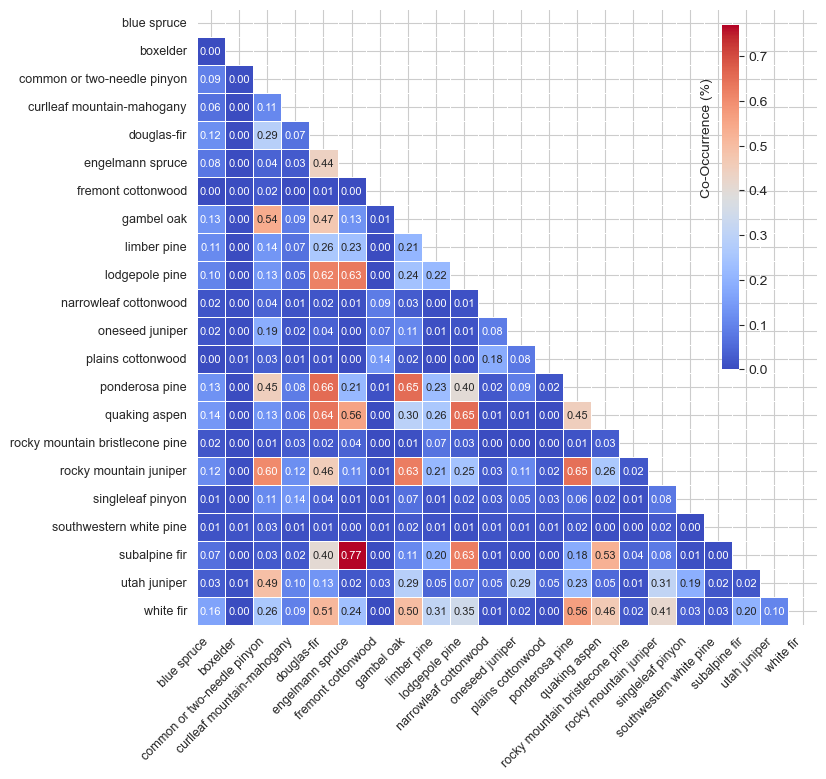

In [25]:
# calculate the species co-occurrence matrix
# see __functions.py
coo_mat, coo_pct = get_spp_coo(
    grid_trees,
    grid_col='grid_idx',
    sp_col='species',
)

# Plot species co-occurrence heatmap
# mask diagonal values (optional)
mask = np.triu(np.ones_like(coo_pct, dtype=bool))

# plot it
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    coo_pct,
    cmap='coolwarm',
    annot=True, fmt=".2f",
    linewidths=0.5,
    mask=mask,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.5}
)

cbar = ax.collections[0].colorbar
cbar.ax.set_position([0.65, 0.43, 2, 0.43])  # [left, bottom, width, height]
cbar.ax.xaxis.set_ticks_position("top")  # Move ticks to top
cbar.ax.xaxis.set_label_position("top")  # Move label to top
cbar.set_label("Co-Occurrence (%)", fontsize=10, labelpad=-48, rotation=90, ha="left")

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("", fontsize=10)
plt.ylabel("", fontsize=10)

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS3_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

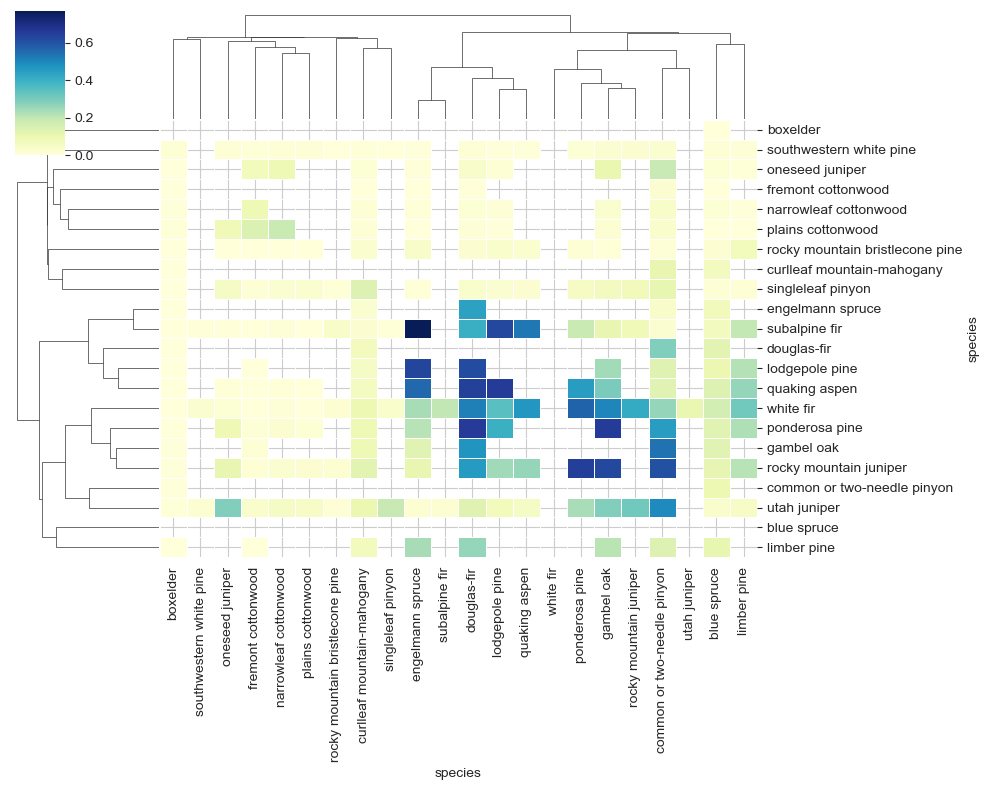

In [26]:
# cluster plot to highlight species groupings
sns.clustermap(
    coo_pct,
    cmap='YlGnBu',
    linewidths=0.5,
    mask=mask,
    figsize=(10, 8)
)

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS3_Species_CoOccurrence_cluster.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

In [27]:
# make some species groupings
# combine pinyon & juniper
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    'engelmann spruce|subalpine fir': 'spruce-fir',
}

# remap the species to groups
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keys, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_trees[grid_trees['species'].str.contains(keys, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})

# Apply the remap to create a new grouped species column
grid_trees['species_gp'] = grid_trees['species'].map(spp_remap).fillna(grid_trees['species'])
# Verify the updated species groups
print(grid_trees[['species', 'species_gp']].drop_duplicates().head(10))

# re-aggregate the summary data
grid_trees = (
    grid_trees.groupby(
        ['grid_idx', 'species_gp'], as_index=False
    ).agg(
        tm_id_n=('tm_id_n', 'sum'),
        ba_live=('ba_live', 'sum'),
        tpa_live=('tpa_live', 'sum'),
        hdr_live=('hdr_live', 'mean'),
        qmd_live=('qmd_live', 'mean'),
        ba_dead=('ba_dead', 'sum'),
        tpa_dead=('tpa_dead', 'sum'),
        ba_live_sum=('ba_live_sum', 'sum'),
        ba_live_pr=('ba_live_pr', 'sum'),
        tpa_live_sum=('tpa_live_sum', 'sum'),
        tpa_live_pr=('tpa_live_pr', 'sum')
    )
)

                   species      species_gp
0              douglas-fir     douglas-fir
1         engelmann spruce      spruce-fir
2               gambel oak      gambel oak
3           lodgepole pine  lodgepole pine
4           ponderosa pine  ponderosa pine
5            quaking aspen   quaking aspen
6            subalpine fir      spruce-fir
7                white fir       white fir
19             limber pine     limber pine
30  rocky mountain juniper   pinon-juniper



Species occurrence counts:
species_gp
douglas-fir                        35932
lodgepole pine                     32964
ponderosa pine                     30185
quaking aspen                      28762
spruce-fir                         26458
pinon-juniper                      22331
gambel oak                         21450
white fir                          19487
limber pine                        10691
blue spruce                         4547
curlleaf mountain-mahogany          2757
rocky mountain bristlecone pine     1089
narrowleaf cottonwood                785
plains cottonwood                    538
southwestern white pine              513
fremont cottonwood                   311
boxelder                              80
Name: count, dtype: int64



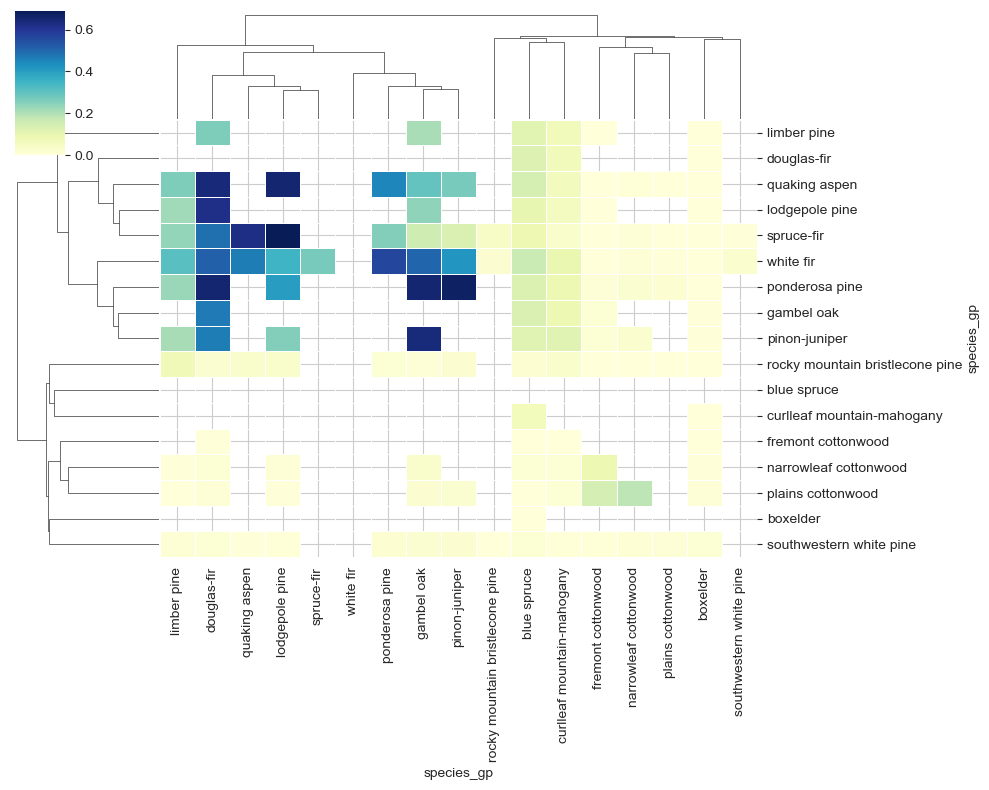

In [28]:
# re-calculate the species co-occurrence matrix
# see __functions.py
coo_mat, coo_pct = get_spp_coo(
    grid_trees,
    grid_col='grid_idx',
    sp_col='species_gp',
)

# Plot species co-occurrence heatmap
# mask diagonal values (optional)
mask = np.triu(np.ones_like(coo_pct, dtype=bool))

sns.clustermap(
    coo_pct,
    cmap='YlGnBu',
    linewidths=0.5,
    mask=mask,
    figsize=(10, 8)
)

In [29]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape total
spp_pr = (
    grid_trees.groupby('species_gp', as_index=False)
    .agg(
        ba_live=('ba_live', 'sum'),
        tpa_live=('tpa_live', 'sum'),
    )
)

# calculate the fractions for both BALIVE and TPA
spp_pr['ba_live_f'] = spp_pr['ba_live'] / spp_pr['ba_live'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_live_f', ascending=False)
spp_pr['ba_live_f_csum'] = spp_pr['ba_live_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()

# which species make up X% of observations?
metric = 'ba_live_f_csum'
thresh = 0.97 # cutoff
top_species = spp_pr[(spp_pr['ba_live_f_csum'] <= thresh) | (spp_pr['tpa_live_f_csum'] <= thresh)]
print(f"\nSpecies making up {round(thresh*100)}% of *{metric}*: \n\n{top_species[['species_gp','ba_live_f','tpa_live_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of *ba_live_f_csum*: 

        species_gp  ba_live_f  tpa_live_f
7   lodgepole pine   0.267792    0.345069
11  ponderosa pine   0.203749    0.094761
15      spruce-fir   0.163235    0.170394
12   quaking aspen   0.130425    0.136487
3      douglas-fir   0.077273    0.041425
9    pinon-juniper   0.067491    0.038939
16       white fir   0.047111    0.026485




88

In [30]:
# subset to the top species a final time
N=len(grid_trees)
grid_trees = grid_trees[grid_trees['species_gp'].isin(top_species['species_gp'].unique())]
print(f"Filtered out {N-len(grid_trees)} rows.")
print(f"\nUnique species: \n{grid_trees['species_gp'].unique()}\n")

Filtered out 42761 rows.

Unique species: 
['douglas-fir' 'lodgepole pine' 'ponderosa pine' 'quaking aspen'
 'spruce-fir' 'white fir' 'pinon-juniper']




Species occurrence counts:
species_gp
douglas-fir       35932
lodgepole pine    32964
ponderosa pine    30185
quaking aspen     28762
spruce-fir        26458
pinon-juniper     22331
white fir         19487
Name: count, dtype: int64



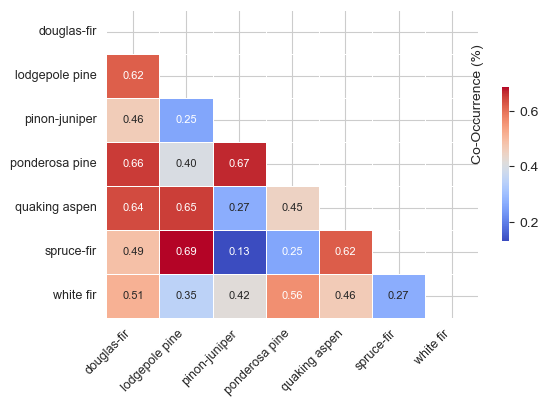

In [34]:
# calculate the species co-occurrence matrix
# see __functions.py
coo_mat, coo_pct = get_spp_coo(
    grid_trees,
    grid_col='grid_idx',
    sp_col='species_gp',
)

# Plot species co-occurrence heatmap
# mask diagonal values (optional)
mask = np.triu(np.ones_like(coo_pct, dtype=bool))

# plot it
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(
    coo_pct,
    cmap='coolwarm',
    annot=True, fmt=".2f",
    linewidths=0.5,
    mask=mask,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.5}
)

cbar = ax.collections[0].colorbar
cbar.set_label("Co-Occurrence (%)", fontsize=10, labelpad=-48, rotation=90, ha="left")

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("", fontsize=10)
plt.ylabel("", fontsize=10)

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS3_Species_CoOccurrence_clusterN97.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

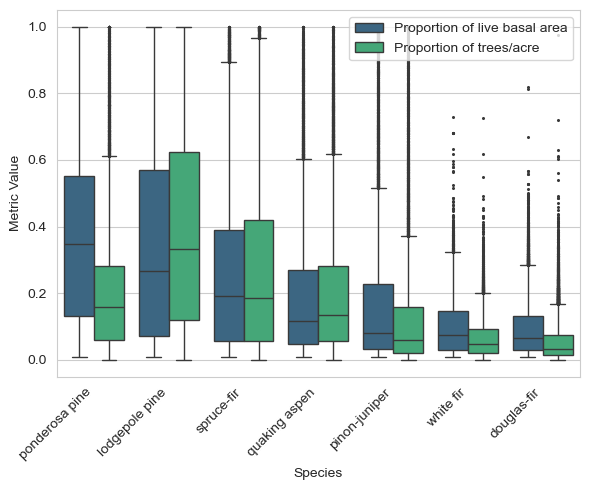

27457

In [35]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_trees.groupby('species_gp')['ba_live_pr']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_l = pd.melt(
    grid_trees,
    id_vars=['species_gp'],
    value_vars=['ba_live_pr', 'tpa_live_pr'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=df_l,
    x='species_gp',
    y='value',
    hue='metric',
    order=sp_order,
    palette='viridis',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Proportion of live basal area', 'Proportion of trees/acre']  # New labels
plt.legend(
    handles=handles,
    labels=new_labels,  # Replace default labels
    title='',
    loc='upper right',
    bbox_to_anchor=(1, 1)
)

# Finalize and show the plot
plt.tight_layout()

# Save the plot
out_png = os.path.join(projdir, 'figures/FigureS1b_TopSpecies_TreeMetrics_Proportions.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df_l
gc.collect()

In [36]:
# calculate the shannon diversity index based on the species present
def shannon_index(group, col):
    proportions = group[col].dropna()  # Remove NaNs if any
    return -np.sum(proportions * np.log(proportions))

# calculate the shannon index for grids
shannon = grid_trees.groupby('grid_idx').apply(lambda g: pd.Series({
    "H_ba": shannon_index(g, "ba_live_pr"),
    "H_tpa": shannon_index(g, "tpa_live_pr")
})).reset_index()
# merge back to the dataframe
grid_trees = grid_trees.merge(shannon, on="grid_idx", how="left")

print(shannon.head())
del shannon

  grid_idx      H_ba     H_tpa
0  0819719  1.102782  0.970404
1  0819720  1.174604  0.991860
2  0819721  1.059572  0.878194
3  0819725  1.175636  0.987529
4  0821970  1.049353  0.962446



Dominance based on *tpa_live*

	~ douglas-fir: 777 grids (1.7%)
	~ lodgepole pine: 16083 grids (34.9%)
	~ ponderosa pine: 11859 grids (25.8%)
	~ quaking aspen: 6559 grids (14.2%)
	~ spruce-fir: 6570 grids (14.3%)
	~ white fir: 601 grids (1.3%)
	~ pinon-juniper: 3591 grids (7.8%)

Dominance based on *ba_live*

	~ douglas-fir: 947 grids (2.1%)
	~ lodgepole pine: 13624 grids (29.6%)
	~ ponderosa pine: 15940 grids (34.6%)
	~ quaking aspen: 5482 grids (11.9%)
	~ spruce-fir: 6103 grids (13.3%)
	~ white fir: 690 grids (1.5%)
	~ pinon-juniper: 3254 grids (7.1%)




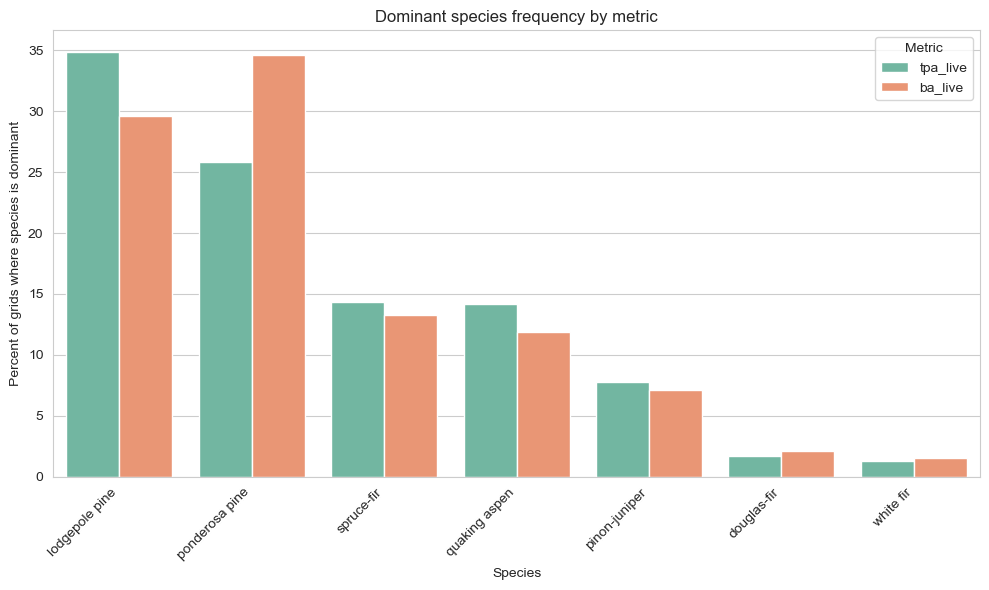

In [37]:
# Identify dominant species for each grid cell by 'balive' or 'tpa_live'
spps = grid_trees['species_gp'].unique()
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpa_live', 'ba_live']  # metrics to assess
dom_dfs = []
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_trees.groupby('grid_idx', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in spps:
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_idx'].unique())
        # Print the results
        total_grids = len(grid_trees['grid_idx'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)

        dom_dfs.append({
            "metric": metric,
            "species_gp": spp,
            "n_dom": n_dom,
            "pct_dom": spp_pct
        })

        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")

# make the dataframe and save
dom_df = pd.DataFrame(dom_dfs)

order = (
    dom_df.groupby("species_gp")["pct_dom"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=dom_df,
    x="species_gp",
    y="pct_dom",
    hue="metric",
    palette="Set2",
    order=order
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Percent of grids where species is dominant")
plt.xlabel("Species")
plt.title("Dominant species frequency by metric")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

del dom_spp, spp_dominant

In [38]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp_idx = grid_trees[grid_trees['species_gp'] == 'quaking aspen']['grid_idx'].unique() # list of grid indices
grid_aspen = grid_trees[grid_trees['grid_idx'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_aspen['grid_idx'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_trees['grid_idx'].unique())*100,1)}%] grids w/ some aspen.")

28762 [62.5%] grids w/ some aspen.


In [39]:
# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
grid_trees.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable.csv


### Handle the FORTYP/FLDTYP summaries

Filter these metrics to only the dominant types identified above.

In [40]:
fortyp = zs_results['fortypcd']
print(len(fortyp['grid_idx'].unique()))
# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
lut = pd.read_csv(fp)
lut = lut[['FORTYPCD','SpeciesName']]
lut.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)
# join in the forest type name
fortyp = pd.merge(fortyp, lut, on='fortypcd', how='left')
fortyp['fortypnm'] = fortyp['fortypnm'].str.lower()
fortyp['fortypnm'] = fortyp['fortypnm'].replace("aspen", "quaking aspen")
print(len(fortyp['grid_idx'].unique()))
fortyp.head()

46054
46054


,grid_idx,fortypcd,count,fortypcd_npix,fortypcd_pct,fortypnm
0,161955422,182,17.0,167.0,10.179641,rocky mountain juniper
1,161955422,201,38.0,167.0,22.754491,douglas-fir
2,161955422,221,26.0,167.0,15.568862,ponderosa pine
3,161955422,261,22.0,167.0,13.173653,white fir
4,161955422,267,21.0,167.0,12.574850,grand fir


In [41]:
# make some species groupings
# combine pinyon & juniper
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    'engelmann spruce|subalpine fir': 'spruce-fir',
}

# remap the species to groups
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keys, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = fortyp[fortyp['fortypnm'].str.contains(keys, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['fortypnm'].unique()})

# Apply the remap to create a new grouped species column
fortyp['fortypnm_gp'] = fortyp['fortypnm'].map(spp_remap).fillna(fortyp['fortypnm'])
# Verify the updated species groups
print(fortyp[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(10))

# re-aggregate the summary data
fortyp_gp = (
    fortyp.groupby(
        ['grid_idx', 'fortypnm_gp'], as_index=False
    ).agg(
        fortypcd_pct=('fortypcd_pct','sum')
    )
)

# filter to keep only species we identified from the tree table
fortyp_gp = fortyp_gp[fortyp_gp['fortypnm_gp'].isin(grid_trees['species_gp'].unique())]
fortyp_gp['fortypnm_gp'].unique()

                   fortypnm               fortypnm_gp
0    rocky mountain juniper             pinon-juniper
1               douglas-fir               douglas-fir
2            ponderosa pine            ponderosa pine
3                 white fir                 white fir
4                 grand fir                 grand fir
5               blue spruce               blue spruce
6            lodgepole pine            lodgepole pine
7           western juniper             pinon-juniper
8  california mixed conifer  california mixed conifer
9             quaking aspen             quaking aspen


array(['douglas-fir', 'ponderosa pine', 'quaking aspen', 'spruce-fir',
       'white fir', 'pinon-juniper', 'lodgepole pine'], dtype=object)

In [42]:
len(fortyp_gp['grid_idx'].unique())

46022

In [43]:
# calculate the dominant forest type by gridcell
fortyp_dom = (
    fortyp_gp.loc[fortyp_gp.groupby("grid_idx")["fortypcd_pct"].idxmax()]
    .reset_index(drop=True)
)
fortyp_dom.head()

,grid_idx,fortypnm_gp,fortypcd_pct
0,0819719,quaking aspen,85.310734
1,0819720,quaking aspen,67.777778
2,0819721,quaking aspen,95.483871
3,0819725,quaking aspen,75.342466
4,0821970,quaking aspen,75.316456


In [44]:
fortyp_dom['fortypnm_gp'].value_counts()

fortypnm_gp
ponderosa pine    15189
lodgepole pine    12507
spruce-fir         6697
quaking aspen      5172
pinon-juniper      3646
douglas-fir        2334
white fir           477
Name: count, dtype: int64

In [45]:
print(len(fortyp_dom[fortyp_dom['grid_idx'].isin(grid_trees['grid_idx'].unique())]))
print(len(fortyp_dom))
print(len(grid_trees['grid_idx'].unique()))

46016
46022
46040


In [46]:
# merge the fortypcd with the tree table summaries
grid_trees_gp = pd.merge(grid_trees, fortyp_dom, on='grid_idx', how='left')
grid_trees_gp.dropna(subset=['fortypnm_gp'], inplace=True)
grid_trees_gp.head()

,grid_idx,species_gp,tm_id_n,ba_live,tpa_live,hdr_live,qmd_live,ba_dead,tpa_dead,ba_live_sum,ba_live_pr,tpa_live_sum,tpa_live_pr,H_ba,H_tpa,fortypnm_gp,fortypcd_pct
0,0819719,douglas-fir,3,83.556202,210.111020,3.580597,11.628614,3.647884,12.036092,2595.573269,0.032192,13430.38315,0.015644,1.102782,0.970404,quaking aspen,85.310734
1,0819719,lodgepole pine,2,63.390365,552.098462,8.345639,3.828758,10.541578,18.054138,2595.573269,0.024422,13430.38315,0.041108,1.102782,0.970404,quaking aspen,85.310734
2,0819719,ponderosa pine,1,35.633466,101.035840,6.287939,8.041438,21.798482,7.017234,2595.573269,0.013729,13430.38315,0.007523,1.102782,0.970404,quaking aspen,85.310734
3,0819719,quaking aspen,29,1601.752707,7780.500598,6.550492,7.396682,556.099480,1311.934028,2595.573269,0.617109,13430.38315,0.579321,1.102782,0.970404,quaking aspen,85.310734
4,0819719,spruce-fir,15,434.118185,2548.153152,5.403073,8.641415,53.162807,120.360920,5191.146539,0.167253,26860.76630,0.189730,1.102782,0.970404,quaking aspen,85.310734


In [47]:
len(grid_trees_gp['grid_idx'].unique())

46016

## Merge in the other summary tables from LANDFIRE and TreeMap

Now we can attach the remaining summary tables (TreeMap and LANDFIRE summaries) and save the final table.

In [48]:
zs_results['forest'].head()

,grid_idx,forest,count,forest_npix,forest_pct
0,161955422,0,15,182,8.241758
1,161955422,1,167,182,91.758242
2,161957669,1,182,182,100.000000
3,161957670,1,196,196,100.000000
4,161957671,1,182,182,100.000000


In [50]:
# prep the forest proportion dataframe (keep just forest percent)
forest = zs_results['forest']
forest = forest[forest['forest'] == 1]
forest.drop(columns=['count','forest','forest_npix'], inplace=True)
zs_results['forest_c'] = forest
del forest

# merge the continuous variables first, tidy the names
# keys = ['cc', 'ch', 'cbd', 'cbh', 'forest_c']
keys = ['cc', 'cbd', 'forest_c']
df_cn = zs_results[keys[0]].copy() # get the first to merge

# merge the rest
for key in keys[1:]:
    print(f"Processing {key}")
    df_cn = df_cn.merge(zs_results[key], on='grid_idx', how='left')

# tidy column names
df_cn.columns = df_cn.columns.str.replace('_mean', '', regex=False)
df_cn.rename(columns={'forest_pct': 'forest_prop'}, inplace=True)

Processing cbd
Processing forest_c


In [51]:
print(df_cn.head())

    grid_idx         cc        cbd  forest_prop
0  161955422  44.820359   9.485030    91.758242
1  161957669  57.197802  11.923077   100.000000
2  161957670  60.051020  15.224490   100.000000
3  161957671  62.912088  16.582418   100.000000
4  161957672  53.704663  12.683938    98.469388


In [52]:
print(f"Number of unique grid cells: {len(df_cn['grid_idx'].unique())}")
print(f"Number of rows in the tree table dataframe: {len(grid_trees_gp)}")
print(f"\tacross {len(grid_trees_gp['grid_idx'].unique())} grid cells.")

Number of unique grid cells: 46211
Number of rows in the tree table dataframe: 196080
	across 46016 grid cells.


In [53]:
# merge the tree table and summary table
grid_attr = pd.merge(grid_trees_gp, df_cn, on='grid_idx', how='left')
print(grid_attr.head())

  grid_idx      species_gp  tm_id_n      ba_live     tpa_live  hdr_live  \
0  0819719     douglas-fir        3    83.556202   210.111020  3.580597   
1  0819719  lodgepole pine        2    63.390365   552.098462  8.345639   
2  0819719  ponderosa pine        1    35.633466   101.035840  6.287939   
3  0819719   quaking aspen       29  1601.752707  7780.500598  6.550492   
4  0819719      spruce-fir       15   434.118185  2548.153152  5.403073   

    qmd_live     ba_dead     tpa_dead  ba_live_sum  ba_live_pr  tpa_live_sum  \
0  11.628614    3.647884    12.036092  2595.573269    0.032192   13430.38315   
1   3.828758   10.541578    18.054138  2595.573269    0.024422   13430.38315   
2   8.041438   21.798482     7.017234  2595.573269    0.013729   13430.38315   
3   7.396682  556.099480  1311.934028  2595.573269    0.617109   13430.38315   
4   8.641415   53.162807   120.360920  5191.146539    0.167253   26860.76630   

   tpa_live_pr      H_ba     H_tpa    fortypnm_gp  fortypcd_pct     

In [54]:
print(f"Number of unique grid cells: {len(grid_attr['grid_idx'].unique())}")

Number of unique grid cells: 46016


In [55]:
# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_tm_lf.csv')
grid_attr.to_csv(out_fp, index=False)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_tm_lf.csv
